In [52]:
import geopandas as gpd
import folium
import requests
from dataretrieval import nwis
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def get_base_map():
    # Create a base map and add layers using geopandas or folium
    pass

def fetch_nldi_data(station):
    # Fetch data from specific USGS URLs using requests and process it with geopandas
    pass

def plot_streamflow(nwis_id):
    # Fetch streamflow data using dataretrieval and plot it using matplotlib
    pass

def create_map(data):
    # Create an interactive map using folium and add layers using fetched data
    pass

def main():
    station = "11335000"

    # Fetch NLDI data
    nldi_data = fetch_nldi_data(station)

    # Create a base map
    base_map = get_base_map()

    # Plotting basin boundary, waterways, and other necessary information on a map
    create_map(nldi_data)

    # Fetch NWIS data for streamflow and plot it
    nwis_id = "USGS-" + station
    plot_streamflow(nwis_id)

    # Further data processing or visualization as needed

if __name__ == "__main__":
    main()


In [3]:
def get_url(service, host="basemap.nationalmap.gov"):
    return f"https://{host}/arcgis/services/{service}/MapServer/WmsServer"

map = folium.Map()

grp = ["USGS Topo", "USGS Shaded Relief", "Hydrography"]
att = ("<a href='https://www.usgs.gov/'>"
       "U.S. Geological Survey</a> | "
       "<a href='https://www.usgs.gov/laws/policies_notices.html'>"
       "Policies</a>")

map.add_child(folium.WmsTileLayer(url=get_url("USGSTopo"),
                                   name=grp[0],
                                   fmt="image/png",
                                   transparent=True,
                                   layers="0",
                                   attr=att))

map.add_child(folium.WmsTileLayer(url=get_url("USGSShadedReliefOnly"),
                                   name=grp[1],
                                   fmt="image/png",
                                   transparent=True,
                                   layers="0",
                                   attr=att))

map.add_child(folium.WmsTileLayer(url=get_url("USGSHydroCached"),
                                   name=grp[2],
                                   fmt="image/png",
                                   transparent=True,
                                   layers="0",
                                   attr=att))

folium.LayerControl(collapsed=False).add_to(map)

In [4]:
station = "11335000"

nldi_urls = {
    "site_data": "https://labs.waterdata.usgs.gov/api/nldi/linked-data/nwissite/USGS-11335000",
    "basin_boundary": "https://labs.waterdata.usgs.gov/api/nldi/linked-data/nwissite/USGS-11335000/basin",
    "UT": "https://labs.waterdata.usgs.gov/api/nldi/linked-data/nwissite/USGS-11335000/navigation/UT/flowlines?distance=999",
    "UM": "https://labs.waterdata.usgs.gov/api/nldi/linked-data/nwissite/USGS-11335000/navigation/UM/flowlines?distance=999",
    "DM": "https://labs.waterdata.usgs.gov/api/nldi/linked-data/nwissite/USGS-11335000/navigation/DM/flowlines?distance=999",
    "UTwqp": "https://labs.waterdata.usgs.gov/api/nldi/linked-data/nwissite/USGS-11335000/navigation/UT/wqp?distance=999",
    "DMwqp": "https://labs.waterdata.usgs.gov/api/nldi/linked-data/nwissite/USGS-11335000/navigation/DM/wqp?distance=999"
}

nldi_data = {}

for name, url in nldi_urls.items():
    # Fetching data using geopandas or equivalent in Python
    nldi_data[name] = gpd.read_file(url)
    print(f"{name} is of type {type(nldi_data[name])} and has {len(nldi_data[name])} features")

UTwqp_html = f'<a href="{nldi_data["UTwqp"].uri}" target="_blank">{nldi_data["UTwqp"].name}</a>'
DMwqp_html = f'<a href="{nldi_data["DMwqp"].uri}" target="_blank">{nldi_data["DMwqp"].name}</a>'

site_data is of type <class 'geopandas.geodataframe.GeoDataFrame'> and has 1 features
basin_boundary is of type <class 'geopandas.geodataframe.GeoDataFrame'> and has 1 features
UT is of type <class 'geopandas.geodataframe.GeoDataFrame'> and has 708 features
UM is of type <class 'geopandas.geodataframe.GeoDataFrame'> and has 81 features
DM is of type <class 'geopandas.geodataframe.GeoDataFrame'> and has 58 features
UTwqp is of type <class 'geopandas.geodataframe.GeoDataFrame'> and has 70 features
DMwqp is of type <class 'geopandas.geodataframe.GeoDataFrame'> and has 178 features


### Creating interactive map

In [5]:
nldi_urls = {
    "site_data": f"https://cida.usgs.gov/nldi/nwissite/USGS-{station}",
    "basin_boundary": f"https://cida.usgs.gov/nldi/nwissite/USGS-{station}/basin",
}

# Create a new Folium map
map = folium.Map()

# Fetching data for basin_boundary
response = requests.get(nldi_urls["basin_boundary"])
basin_boundary_data = response.json()  # Assuming the response is in JSON format

# Adding polygons to the map for basin_boundary
folium.GeoJson(basin_boundary_data, style_function=lambda x: {'color': 'black', 'fillColor': 'black', 'weight': 1, 'fillOpacity': 0}).add_to(map)


# Add polylines and layers for the upstream main stem
folium.PolyLine(locations=nldi_data["UM"].geometry.apply(lambda x: x.coords), color='blue', weight=3, opacity=0.5).add_to(map)
folium.PolyLine(locations=nldi_data["UT"].geometry.apply(lambda x: x.coords), color='blue', weight=1, opacity=1).add_to(map)
folium.PolyLine(locations=nldi_data["DM"].geometry.apply(lambda x: x.coords), color='blue', weight=3, opacity=0.5).add_to(map)


for idx, row in nldi_data["UTwqp"].iterrows():
    folium.CircleMarker(location=[row.geometry.y, row.geometry.x], radius=1, color='black',
                        opacity=0.5, fill=False, popup=row['name']).add_to(map)

for idx, row in nldi_data["site_data"].iterrows():
    folium.CircleMarker(location=[row.geometry.y, row.geometry.x], radius=5, color='red').add_to(map)

for idx, row in nldi_data["DMwqp"].iterrows():
    folium.CircleMarker(location=[row.geometry.y, row.geometry.x], radius=1, color='black',
                        opacity=0.5, fill=False, popup=row['name']).add_to(map)

map


In [53]:
nwis_gage_url = "https://labs.waterdata.usgs.gov/api/nldi/linked-data/nwissite/USGS-11335000/navigation/UM/nwissite?distance=150"

# Fetch data from the URL
nwis_gages = gpd.read_file(nwis_gage_url)
nwis_ids = nwis_gages['identifier'].astype(str)
print("The NLDI ID for:", nwis_gages['name'], "is", nwis_ids)

# Remove 'USGS-' prefix from IDs
nwis_ids = nwis_ids.str.replace("USGS-", "")
print(nwis_gages['name'], "has id", nwis_ids)

The NLDI ID for: 0        COSUMNES R A MICHIGAN BAR CA
1           COSUMNES R NR PLYMOUTH CA
2       NF COSUMNES R NR EL DORADO CA
3    NF COSUMNES R A COSUMNES MINE CA
Name: name, dtype: object is 0    USGS-11335000
1    USGS-11334500
2    USGS-11333500
3    USGS-11330000
Name: identifier, dtype: object
0        COSUMNES R A MICHIGAN BAR CA
1           COSUMNES R NR PLYMOUTH CA
2       NF COSUMNES R NR EL DORADO CA
3    NF COSUMNES R A COSUMNES MINE CA
Name: name, dtype: object has id 0    11335000
1    11334500
2    11333500
3    11330000
Name: identifier, dtype: object


In [54]:
siteNumber = "11335000" # COSUMNES R A MICHIGAN BAR CA
parameterCode = "00060" # Discharge/streamflow
startDate = "1900-10-01"
endDate = "2023-11-30"

# Retrieve the data
dailyStreamflow = nwis.get_dv(sites=siteNumber, parameterCd=parameterCode, start=startDate, end=endDate)
print("Retrieved " + str(len(dailyStreamflow[0])) + " data values.")

Retrieved 42429 data values.


In [55]:
display(dailyStreamflow[0])

00060_Mean 00060_Mean_cd   site_no
datetime                                                     
1907-10-01 00:00:00+00:00        67.0             A  11335000
1907-10-02 00:00:00+00:00        67.0             A  11335000
1907-10-03 00:00:00+00:00        67.0             A  11335000
1907-10-04 00:00:00+00:00        67.0             A  11335000
1907-10-05 00:00:00+00:00        67.0             A  11335000
...                               ...           ...       ...
2023-11-26 00:00:00+00:00        81.8             P  11335000
2023-11-27 00:00:00+00:00        80.1             P  11335000
2023-11-28 00:00:00+00:00        78.7             P  11335000
2023-11-29 00:00:00+00:00        77.1             P  11335000
2023-11-30 00:00:00+00:00        76.7             P  11335000

[42429 rows x 3 columns]

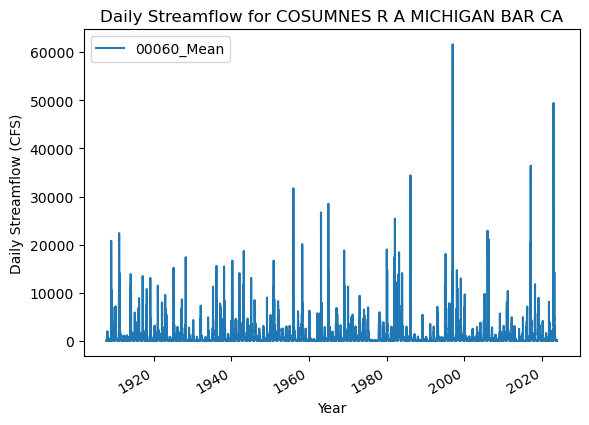

In [30]:
ax = dailyStreamflow[0].plot(y='00060_Mean')
ax.set_xlabel('Date')
ax.set_ylabel('Streamflow (cfs)')
plt.title("Daily Streamflow for " + nwis_gages['name'][0])
plt.xlabel("Year")
plt.ylabel("Daily Streamflow (CFS)")
plt.show()

In [31]:
# from matplotlib.animation import FuncAnimation

# fig, ax = plt.subplots()
# metadata = dict(title='Streamflow Animation', artist='Matplotlib')

# def update(frame):
#     ax.clear()
#     ax.plot(dailyStreamflow[0].index[:frame], dailyStreamflow[0]['00060_Mean'][:frame])
#     ax.set_xlabel('Date')
#     ax.set_ylabel('Streamflow (cfs)')
#     plt.title("Daily Streamflow for " + nwis_gages['name'][0])

# ani = FuncAnimation(fig, update, frames=len(dailyStreamflow[0]), interval=200)
# ani.save('streamflow_animation.mp4', writer='ffmpeg', metadata=metadata)
# plt.show()


# # Wayyyyy toooo looong don't run again 

Retrieved 333 data values.


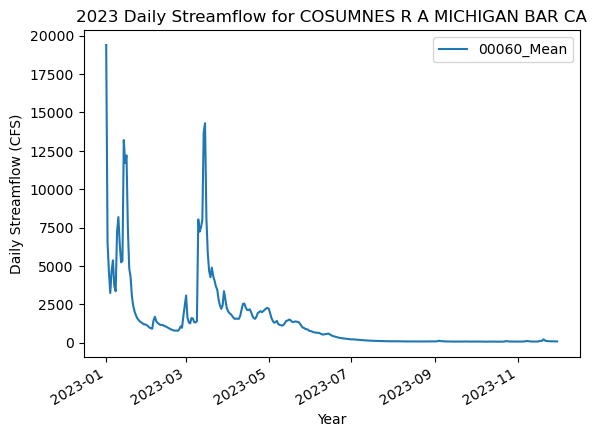

In [56]:
siteNumber = "11335000" # COSUMNES R A MICHIGAN BAR CA
parameterCode = "00060" # Discharge/streamflow
startDate = "2023-01-01"
endDate = "2023-11-30"

# Retrieve the data
dailyStreamflow1 = nwis.get_dv(sites=siteNumber, parameterCd=parameterCode, start=startDate, end=endDate)
print("Retrieved " + str(len(dailyStreamflow1[0])) + " data values.")

ax = dailyStreamflow1[0].plot(y='00060_Mean')
ax.set_xlabel('Date')
ax.set_ylabel('Streamflow (cfs)')
plt.title("2023 Daily Streamflow for " + nwis_gages['name'][0])
plt.xlabel("Year")
plt.ylabel("Daily Streamflow (CFS)")
plt.show()

In [11]:
display(dailyStreamflow1)

(                           00060_Mean 00060_Mean_cd   site_no
 datetime                                                     
 2023-01-01 00:00:00+00:00     19400.0             P  11335000
 2023-01-02 00:00:00+00:00      6520.0             P  11335000
 2023-01-03 00:00:00+00:00      4620.0             P  11335000
 2023-01-04 00:00:00+00:00      3230.0             P  11335000
 2023-01-05 00:00:00+00:00      4670.0             P  11335000
 ...                               ...           ...       ...
 2023-11-26 00:00:00+00:00        81.8             P  11335000
 2023-11-27 00:00:00+00:00        80.1             P  11335000
 2023-11-28 00:00:00+00:00        78.7             P  11335000
 2023-11-29 00:00:00+00:00        77.1             P  11335000
 2023-11-30 00:00:00+00:00        76.7             P  11335000
 
 [333 rows x 3 columns],
 NWIS_Metadata(url=https://waterservices.usgs.gov/nwis/dv?format=json&startDT=2023-01-01&endDT=2023-11-30&sites=11335000&parameterCd=00060))

### Simulation 1 for stream flow from Jan 2023 to ~Dec 2023

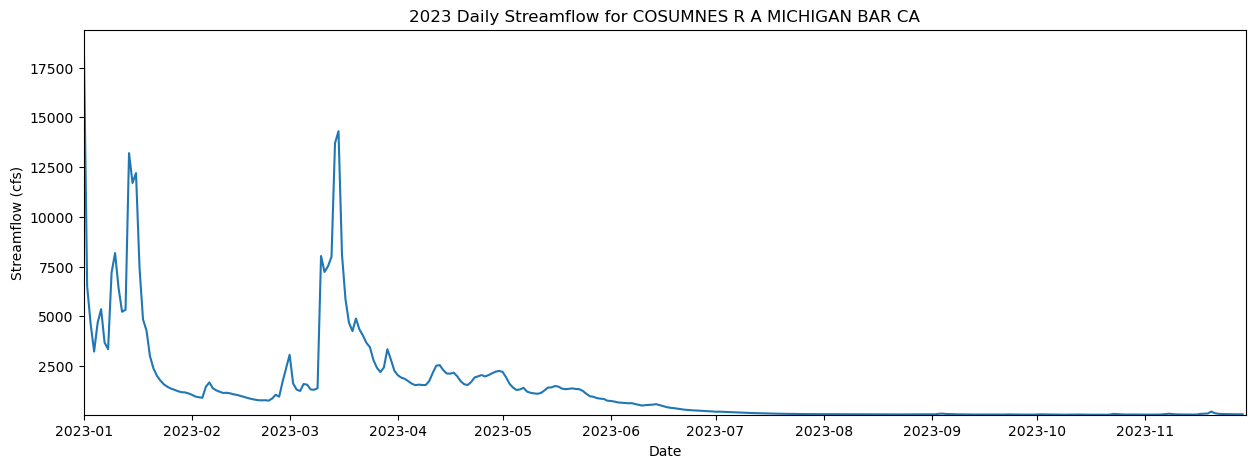

In [51]:
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots(figsize=(15, 5))  # Adjust the figsize as needed
metadata = dict(title='Streamflow Animation', artist='Matplotlib')

# Assuming dailyStreamflow1 is your dataset
x_data = dailyStreamflow1[0].index
y_data = dailyStreamflow1[0]['00060_Mean']

# Determine the initial axis limits based on the entire dataset
x_min = x_data.min()
x_max = x_data.max()
y_min = y_data.min()
y_max = y_data.max()

ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

def update(frame):
    ax.clear()
    ax.plot(x_data[:frame], y_data[:frame])
    ax.set_xlabel('Date')
    ax.set_ylabel('Streamflow (cfs)')
    plt.title("2023 Daily Streamflow for " + nwis_gages['name'][0])

    # Reapply the fixed axis limits in each frame update
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

ani = FuncAnimation(fig, update, frames=len(dailyStreamflow1[0]), interval=200)
ani.save('animation.mp4', writer='ffmpeg', metadata=metadata)
plt.show()


### Plotting historical data of temperature variation

In [15]:
siteNumber = "11335000"  # COSUMNES R A MICHIGAN BAR CA
parameterCode = "00010"  # Temperature
startDate = "1965-10-01"
endDate = "2015-12-02"

# Retrieve the data
dailyTemperature = nwis.get_dv(sites=siteNumber, parameterCd=parameterCode, start=startDate, end=endDate)
print("Retrieved " + str(len(dailyTemperature[0])) + " data values.")

Retrieved 5923 data values.


In [16]:
# Display the data frame as a table
dailyTemperature[0]

00010_Maximum 00010_Maximum_cd   site_no  \
datetime                                                              
1965-10-01 00:00:00+00:00           20.0                A  11335000   
1965-10-02 00:00:00+00:00           20.6                A  11335000   
1965-10-03 00:00:00+00:00           19.4                A  11335000   
1965-10-04 00:00:00+00:00           21.1                A  11335000   
1965-10-05 00:00:00+00:00           20.6                A  11335000   
...                                  ...              ...       ...   
2015-11-28 00:00:00+00:00            7.8                A  11335000   
2015-11-29 00:00:00+00:00            7.0                A  11335000   
2015-11-30 00:00:00+00:00            6.3                A  11335000   
2015-12-01 00:00:00+00:00            7.0                A  11335000   
2015-12-02 00:00:00+00:00            7.3                A  11335000   

                           00010_Minimum 00010_Minimum_cd  00010_Median  \
datetime                                                                  
1965-10-01 00:00:00+00:00           17.2                A           NaN   
1965-10-02 00:00:00+00:00           17.2                A           NaN   
1965-10-03 00:00:00+00:00           16.7                A           NaN   
1965-10-04 00:00:00+00:00           17.2                A           NaN   
1965-10-05 00:00:00+00:00           17.2                A           NaN   
...                                  ...              ...           ...   
2015-11-28 00:00:00+00:00            5.5                A           6.3   
2015-11-29 00:00:00+00:00            5.0                A           5.7   
2015-11-30 00:00:00+00:00            4.8                A           5.3   
2015-12-01 00:00:00+00:00            4.7                A           5.2   
2015-12-02 00:00:00+00:00            5.2                A           6.2   

                          00010_Median_cd  
datetime                                   
1965-10-01 00:00:00+00:00             NaN  
1965-10-02 00:00:00+00:00             NaN  
1965-10-03 00:00:00+00:00             NaN  
1965-10-04 00:00:00+00:00             NaN  
1965-10-05 00:00:00+00:00             NaN  
...                                   ...  
2015-11-28 00:00:00+00:00               A  
2015-11-29 00:00:00+00:00               A  
2015-11-30 00:00:00+00:00               A  
2015-12-01 00:00:00+00:00               A  
2015-12-02 00:00:00+00:00               A  

[5923 rows x 7 columns]

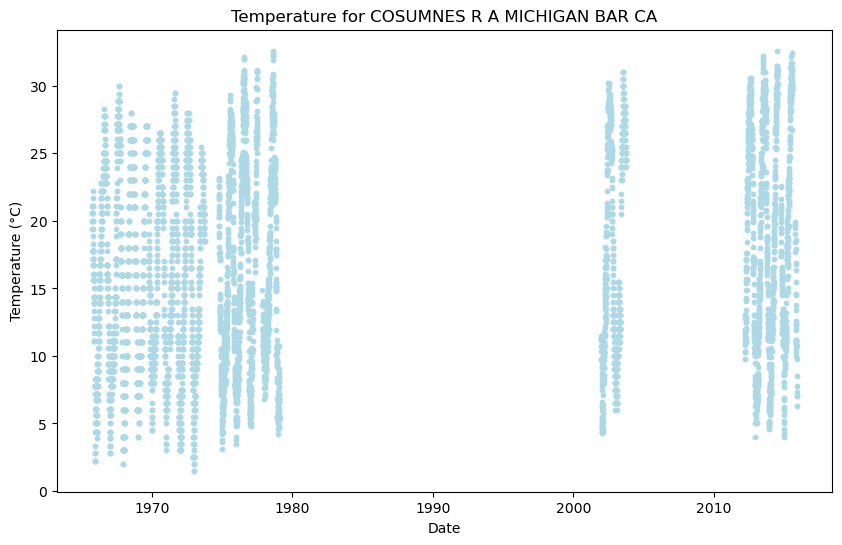

In [25]:
plt.figure(figsize=(10, 6))
plt.scatter(dailyTemperature[0].index, dailyTemperature[0]['00010_Maximum'], marker='o', color='lightblue', s=10)
plt.title("Temperature for COSUMNES R A MICHIGAN BAR CA")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.show()

Retrieved 5923 data values.


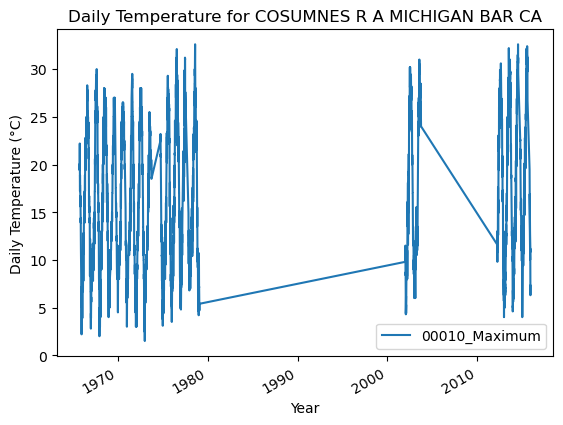

In [26]:
# Set the parameters needed to retrieve data
siteNumber = "11335000" # COSUMNES R A MICHIGAN BAR CA
parameterCode = "00010" # Temperature
startDate = "1965-10-01"
endDate = "2015-12-02"

# Retrieve the data
dailyTemperature = nwis.get_dv(sites=siteNumber, parameterCd=parameterCode, start=startDate, end=endDate)
print("Retrieved " + str(len(dailyTemperature[0])) + " data values.")

ax = dailyTemperature[0].plot(y='00010_Maximum')
ax.set_xlabel('Date')
ax.set_ylabel('Temperature (cfs)')
plt.title("Daily Temperature for " + nwis_gages['name'][0])
plt.xlabel("Year")
plt.ylabel("Daily Temperature (°C)")
plt.show()

### Plotting and simulating Temperature from Jan 2015 to ~Dec 2015

Retrieved 364 data values.
Retrieved 5923 data values.


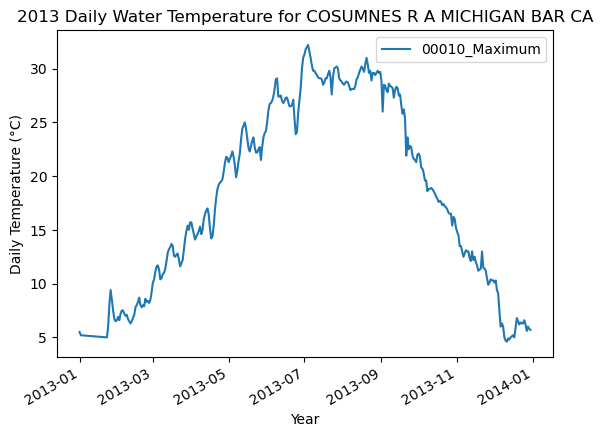

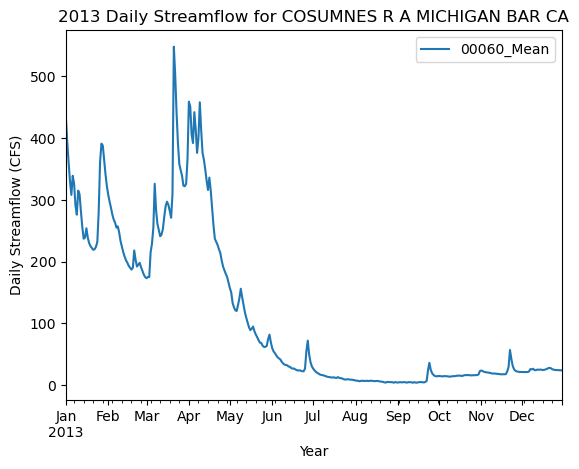

In [37]:
# Set the parameters needed to retrieve data
siteNumber = "11335000" # COSUMNES R A MICHIGAN BAR CA
parameterCode1 = "00060"
parameterCode2 = "00010" # Temperature
startDate = "2013-01-01"
endDate = "2013-12-30"

# Retrieve the data

dailyStreamflow2 = nwis.get_dv(sites=siteNumber, parameterCd=parameterCode1, start=startDate, end=endDate)
print("Retrieved " + str(len(dailyStreamflow2[0])) + " data values.")

dailyTemperature1 = nwis.get_dv(sites=siteNumber, parameterCd=parameterCode2, start=startDate, end=endDate)
print("Retrieved " + str(len(dailyTemperature[0])) + " data values.")

ax = dailyTemperature1[0].plot(y='00010_Maximum')
ax.set_xlabel('Date')
ax.set_ylabel('Temperature (°C)')
plt.title("2013 Daily Water Temperature for " + nwis_gages['name'][0])
plt.xlabel("Year")
plt.ylabel("Daily Temperature (°C)")
plt.show()

ax = dailyStreamflow2[0].plot(y='00060_Mean')
ax.set_xlabel('Date')
ax.set_ylabel('Streamflow (cfs)')
plt.title("2013 Daily Streamflow for " + nwis_gages['name'][0])
plt.xlabel("Year")
plt.ylabel("Daily Streamflow (CFS)")
plt.show()

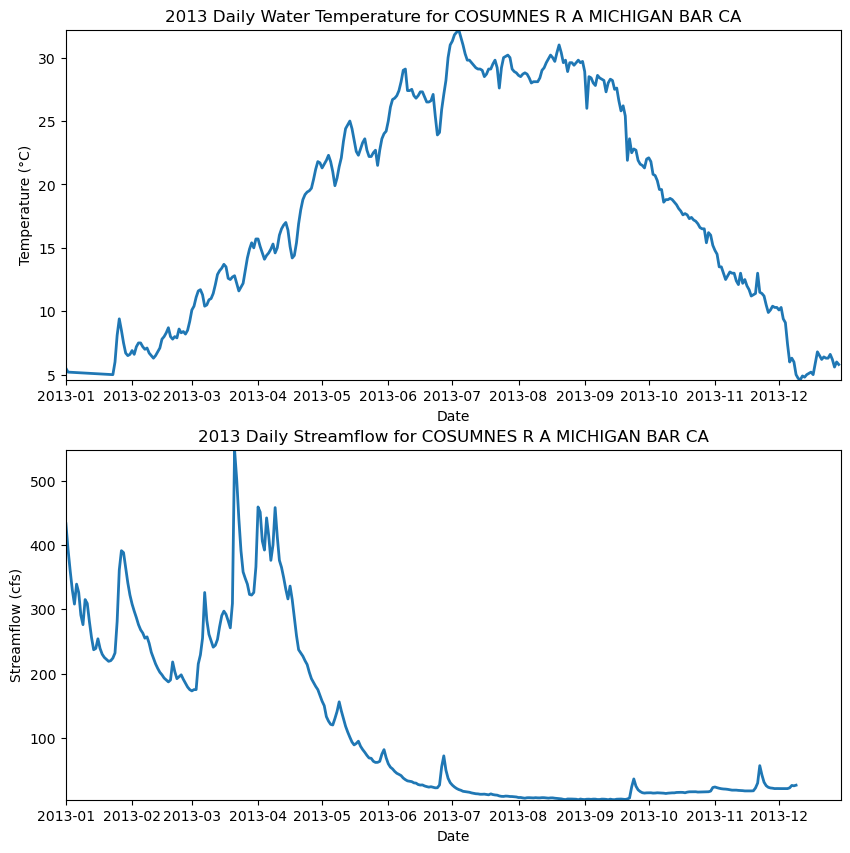

In [43]:
from matplotlib.animation import FuncAnimation, FFMpegWriter

# Set the figure size
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

# Plot for Temperature
line_temp, = ax1.plot([], [], lw=2)
ax1.set_xlabel('Date')
ax1.set_ylabel('Temperature (°C)')
ax1.set_title("2013 Daily Water Temperature for " + nwis_gages['name'][0])

# Plot for Streamflow
line_flow, = ax2.plot([], [], lw=2)
ax2.set_xlabel('Date')
ax2.set_ylabel('Streamflow (cfs)')
ax2.set_title("2013 Daily Streamflow for " + nwis_gages['name'][0])

# Update function for animation
def update(i):
    x_temp = dailyTemperature1[0].index[:i]
    y_temp = dailyTemperature1[0]['00010_Maximum'].values[:i]
    line_temp.set_data(x_temp, y_temp)

    x_flow = dailyStreamflow2[0].index[:i]
    y_flow = dailyStreamflow2[0]['00060_Mean'].values[:i]
    line_flow.set_data(x_flow, y_flow)

    # Set fixed x and y-axis limits
    ax1.set_xlim(dailyTemperature1[0].index[0], dailyTemperature1[0].index[-1])
    ax1.set_ylim(min(dailyTemperature1[0]['00010_Maximum']), max(dailyTemperature1[0]['00010_Maximum']))
    ax2.set_xlim(dailyStreamflow2[0].index[0], dailyStreamflow2[0].index[-1])
    ax2.set_ylim(min(dailyStreamflow2[0]['00060_Mean']), max(dailyStreamflow2[0]['00060_Mean']))

    return line_temp, line_flow

# Create the animation
num_frames = min(len(dailyTemperature1[0]), len(dailyStreamflow2[0]))
animation = FuncAnimation(fig, update, frames=num_frames, interval=50, blit=True)

# Set up formatting for the movie files
writer = FFMpegWriter(fps=15, metadata=dict(artist='Me'), bitrate=1800)

# Save the animation as a video file
animation_filename = 'animation1.mp4'
animation.save(animation_filename, writer=writer)

plt.show()